Modeling: Ran lasso, SVM, and random forest to see the mean square error when it comes to predicting age 

Can't get SVM to run :/ 

Used KNN to find predict Age group

Ran KMeans clustering to see interesting clusters.

Still need to try and use countvectorizer

Data Dictionary

1.	distance_from_dealer - distance of customer from the dealership
2.	sales_source - what channel the car was sold on (eBay, Autotrader,etc)
3.	free_shipping_cost - cost to ship the car to the customer (we offer free shipping)
4.	stock_number - unique id for the car sold
5.  car_class - description of the car. Example - SUV, Luxury
6.  body - body style of the car (sedan, convertible,etc)
7.  color - exterior color
8.  year - year of the car
9.  make - brand of the car (BMW, Ford, etc)
10. model - model of the car (F150, Corvette, etc)
11. mileage - miles driven on the car
12. age - # of days for the car to sell
13. trade_acv - $ amount if customer traded their car in to buy another
14. acquisition_cost - cost for us to acquire the car that was sold
15. reconditioning_cost - cost for us to recondition the car before selling
16. total_cost - total cost to us
17. sale_price - price of the car when it was sold
18. front_gross - profit to us from the sale
19. financing - profit to us if buyer opted to finance with us
20. warranty - profit to us if buyer purchased a warranty
21. insurance - profit to us if buyer purchased insurance
22. other_products - profit to us if buyer purchased other products
23. theft - disregard
24. ultimate - disregard
25. dent/ding - disregard
26. windshield - disregard
27. tire/wheel - disregard
28. roadside - disregard
29. bank_fees - disregard
30. back_gross - Total profit off all add-ons (financing, warranty etc)
31. total_gross - front gross + back gross

In [3152]:
import pandas as pd
import numpy as np
import math
from sklearn.ensemble.forest import RandomForestRegressor
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import train_test_split
from patsy import dmatrices, dmatrix
from sklearn.linear_model import Lasso
from sklearn.cross_validation import KFold, cross_val_score
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import RandomizedPCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.svm import SVC
import matplotlib.pyplot as plt
%matplotlib inline

In [3153]:
df = pd.read_csv('merch_data.csv')
pd.set_option('display.max_rows', 500)

In [3154]:
df.columns

Index([u'Distance from dealer', u'Sales Source', u'Free Shipping Cost',
       u'Stock Number', u'Car Class', u'Body', u'Color', u'Year', u'Make',
       u'Model', u'Mileage', u'Age', u'Trade ACV', u'Acquisition Cost',
       u'RECONDITIONING COST', u'Total Cost', u'Sale Price', u'Front Gross',
       u'Financing', u'warranty', u'insurance', u'other_products', u'Theft',
       u'Ultimate', u'Dent/Ding', u'Windshield', u'Tire/Wheel', u'Roadside',
       u'Bank Fees', u'Back Gross', u'Total Gross'],
      dtype='object')

In [3155]:
# clean up column names
df.columns = df.columns.str.replace(' ','_')
df.columns = [x.lower() for x in df.columns]

In [3157]:
# remove feature if null count is above 1000
null_cnts = df.isnull().sum()
headers = []
for x in null_cnts.keys():
    if null_cnts[x]<=1200:
        headers.append(x)

In [3158]:
data = df[headers]
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1340 entries, 0 to 1339
Data columns (total 24 columns):
distance_from_dealer    1340 non-null float64
sales_source            1340 non-null object
free_shipping_cost      259 non-null float64
stock_number            1340 non-null object
car_class               1105 non-null object
body                    1096 non-null object
color                   1000 non-null object
year                    1340 non-null int64
make                    1340 non-null object
model                   1340 non-null object
mileage                 1340 non-null int64
age                     1340 non-null int64
trade_acv               722 non-null float64
acquisition_cost        1340 non-null int64
reconditioning_cost     1340 non-null float64
total_cost              1340 non-null float64
sale_price              1340 non-null int64
front_gross             1340 non-null float64
financing               1340 non-null float64
warranty                1340 non-null 

In [3159]:
# fill in null values 
data['free_shipping_cost'] = data['free_shipping_cost'].fillna(0)
data['trade_acv'] = data['trade_acv'].fillna(0)
data = data.fillna('missing, missing')

/Users/daniellee/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Users/daniellee/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [3160]:
data.head()

,distance_from_dealer,sales_source,free_shipping_cost,stock_number,car_class,body,color,year,make,model,...,reconditioning_cost,total_cost,sale_price,front_gross,financing,warranty,insurance,other_products,back_gross,total_gross
0,0.000,Repeat Customer,150.000,45239645,"missing, missing","missing, missing","missing, missing",14,FORD,MUST,...,1117.970,30105.970,30996,865.030,0.000,0,0,0,0.000,865.030
1,217.874,Autotrader,150.000,15101926,"missing, missing","missing, missing","missing, missing",11,CHEV,CORV,...,2508.670,53976.670,54696,694.330,2047.530,1000,0,0,3047.530,3741.860
2,1090.956,Google,750.000,5S766179,"Car, Luxury Sport",2D Coupe,"missing, missing",13,PORS,911,...,1376.660,118644.660,119996,726.340,734.290,0,0,0,734.290,1460.630
3,1324.470,eBay,750.000,9F009429,"Car, Luxury Sport",2D Convertible,Silver,3,MB,SL500R,...,2885.650,18353.650,17796,-1182.650,0.000,0,0,0,0.000,-1182.650
4,33.700,Cargurus,0.000,1FC89588,"Truck, Large Pick-up",2D Standard Cab,"missing, missing",11,FORD,F150,...,391.840,15359.840,16998,1763.160,0.000,0,0,0,0.000,1763.160


In [3161]:
# reduce number of sales sources by grouping into broader groups
def update_sales_source(x):
    if x in('repeat customer','referral','dealer','known other','truecar','craigslist'):
        return 'known_other'
    elif x in('unknown','website','drive by'):
        return 'unknown'
    else:
        return x

data['sales_source'] = data.sales_source.apply(lambda x: x.lower())
data['sales_source'] = data.sales_source.apply(update_sales_source)

In [3162]:
data.sales_source.unique()

array(['known_other', 'autotrader', 'google', 'ebay', 'cargurus',
       'cars.com', 'unknown', 'kbb'], dtype=object)

In [3163]:
# create additional features from car class
data['car_class'].value_counts()

missing, missing                   235
Truck, Large Pick-up               180
Car, Intermediate                  134
SUV, Luxury Sport Utility          132
Car, Luxury Sport                  122
Car, Luxury                         91
SUV, Intermediate Sport Utility     79
Car, Compact                        77
Car, Luxury High                    75
SUV, Compact Sport Utility          69
Car, Sport                          40
SUV, Large Sport Utility            28
Car, Subcompact                     22
Van, Small Van                      21
Van, Full Size Vans                 20
Truck, Small Pick-up                15
dtype: int64

In [3164]:
data['primary_class'] = data.car_class.apply(lambda x: x.split(', ')[0].split()[0])
data['secondary_class'] = data.car_class.apply(lambda x: x.split(', ')[1].split()[0])

In [3165]:
# create acquisition source feature (where we got the car)
def acq_source(x):
    if str(x)[0] in('1','2'):
        return 'consumer_trade'
    elif str(x)[0] in('3','4','5'):
        return 'auction_purchase'
    elif str(x)[0] == '7':
        return 'dealer_purchase'
    elif str(x)[0] in('8','9'):
        return 'consumer_purchase'
    
data['acq_source'] = clean.stock_number.apply(acq_source)

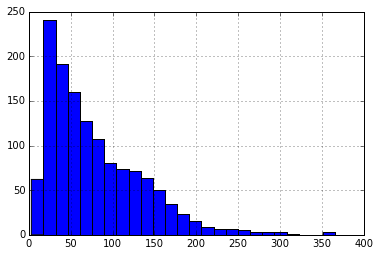

In [3167]:
# see how is age of sale distributed
data.age.hist(bins=25)

In [3168]:
# based on visualization, group ages into buckets
def age_groups(x):
    if x <= 35:
        return 'fast'
    elif x <=60:
        return 'good'
    elif x <=90:
        return 'average'
    else:
        return 'poor'

data['age_group'] = data.age.apply(age_groups)

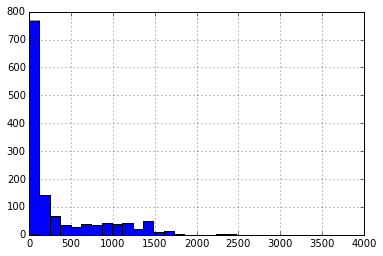

In [3169]:
# see how distance from dealership is distributed
data.distance_from_dealer.hist(bins=30)

In [3170]:
# based on visualization, distance from dealership into buckets
def dealer_range(x):
    if x <= 100:
        return '0-100'
    elif x <= 200:
        return '101-200'
    else:
        return '201+'
    
data['dealer_range'] = clean.distance_from_dealer.apply(dealer_range)

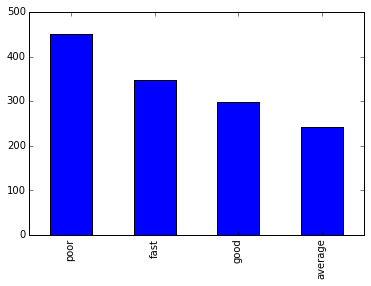

In [3171]:
# see how our sales are distributed by age group
data.age_group.value_counts().plot(kind='bar')

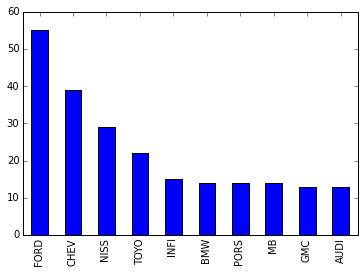

In [3172]:
# take a look at sales by make of car for cars that sold fast
data[data.age_group == 'fast'].make.value_counts().head(10).plot(kind='bar')

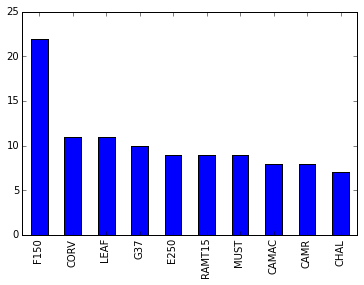

In [3173]:
# sales by car model for cars that sold fast
data[data.age_group == 'fast'].model.value_counts().head(10).plot(kind='bar')

In [3174]:
data[data.age_group == 'fast'].model.describe()

count      348
unique     165
top       F150
freq        22
Name: model, dtype: object

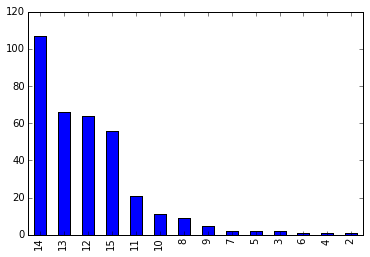

In [3175]:
data[data.age_group == 'fast'].year.value_counts().plot(kind='bar')

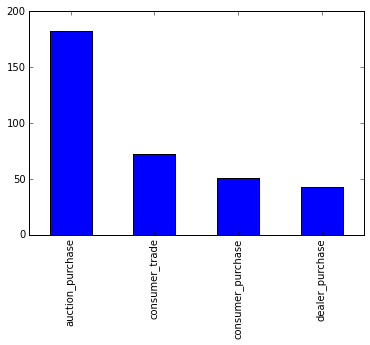

In [3176]:
# distribution of acquisition source for fast sellers
data[data.age_group == 'fast'].acq_source.value_counts().plot(kind='bar')

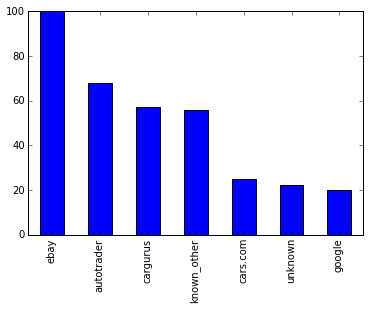

In [3177]:
# distribution of sales source for fast sellers
data[data.age_group == 'fast'].sales_source.value_counts().plot(kind='bar')

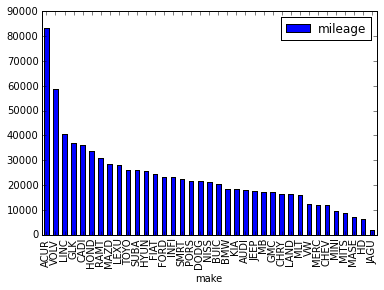

In [3178]:
# average mileage by make for fast sellers
makes = data[['make','mileage','age_group']]
makes = makes[makes.age_group == 'fast']
makes = makes[['make','mileage']]
makes_group = makes.groupby('make')
avg_mileage = makes_group.mean().sort('mileage', ascending=False)
avg_mileage.plot(kind='bar')

In [3271]:
#pd.tools.plotting.scatter_matrix(data, figsize=(20,20), diagonal='kde')

In [3180]:
# get features that are ints and floats
num_features = []
for x in data.columns:
    if data[x].dtype in ('int64','float64'):
        num_features.append(x)

num_features

['distance_from_dealer',
 'free_shipping_cost',
 'year',
 'mileage',
 'age',
 'trade_acv',
 'acquisition_cost',
 'reconditioning_cost',
 'total_cost',
 'sale_price',
 'front_gross',
 'financing',
 'warranty',
 'insurance',
 'other_products',
 'back_gross',
 'total_gross']

In [3181]:
# remove age from features since we're predicting this
# remove features that we know AFTER the car is sold i.e. gross profit etc...
#remove total cost since this is made up of acq and recon cost
# this shouldn't help us determine how fast a car sells
num_features = ['distance_from_dealer',
 'free_shipping_cost',
 'year',
 'mileage',
 'acquisition_cost',
 'reconditioning_cost',
 'sale_price']

In [3182]:
tweaked_num = ' + '.join(num_features)
tweaked_num

'distance_from_dealer + free_shipping_cost + year + mileage + acquisition_cost + reconditioning_cost + sale_price'

In [3183]:
# get features that are strings
obj_features = []
for x in data.columns:
    if data[x].dtype == 'object':
        obj_features.append(x)
        
obj_features

['sales_source',
 'stock_number',
 'car_class',
 'body',
 'color',
 'make',
 'model',
 'primary_class',
 'secondary_class',
 'acq_source',
 'age_group',
 'dealer_range']

In [3287]:
# remove age group since we're also trying to predict this
# remove features like stock_number and car_class which have more granular features built off of them
#'sales_source' since this is known after the sale
obj_features = [
 'body',
 'color',
 'make',
 'model',
 'acq_source',
 'dealer_range']

In [3288]:
tweaked_obj = ') + C('.join(obj_features)
tweaked_obj = "C("+ tweaked_obj + ")"
tweaked_obj

'C(body) + C(color) + C(make) + C(model) + C(acq_source) + C(dealer_range)'

In [3289]:
# does dmatrices do the samething as pd.factorize(data['x']) to categoricals????
y, X = dmatrices('age ~ 0 +' + tweaked_num + '+' + tweaked_obj , data, return_type = 'dataframe')
#flatter y to a list
y = np.ravel(y)

In [3290]:
# fit data to the model first try
ls = Lasso(max_iter=100)
ls.fit(X, y) #<- predicting y given X
np.abs(cross_val_score(ls, X, y, scoring='mean_absolute_error', cv=10).mean())

37.030657526924074

In [3291]:
# scale data to improve lasso cv score
# scaling equalizes the rate variables move and removes the units - addresses outliers
scalerx = StandardScaler(copy=True)
scalery = StandardScaler(copy=True)
X_scaled = scalerx.fit(X).transform(X)
y_scaled = scalery.fit(y).transform(y)

In [3292]:
# fit data to the model 2nd try
# result is 0.8 sd off from mean
ls_scale = Lasso(max_iter=100) #scales features
ls_scale.fit(X_scaled, y_scaled) #<- predicting y given X
np.abs(cross_val_score(ls, X_scaled, y_scaled, scoring='mean_absolute_error', cv=10).mean())

0.79693381674632691

In [2992]:
# prediction =[]
# predictionscaled = scalerx.fit(prediction)
# lscaled.predict(predictionscaled)

In [2993]:
d = {'features': X.columns, 'coefficients': ls.coef_}
pd.DataFrame(d)

,coefficients,features
0,-0.000,C(sales_source)[autotrader]
1,-0.000,C(sales_source)[cargurus]
2,0.000,C(sales_source)[cars.com]
3,-0.000,C(sales_source)[ebay]
4,-0.000,C(sales_source)[google]
5,0.000,C(sales_source)[kbb]
6,3.548,C(sales_source)[known_other]
7,-0.000,C(sales_source)[unknown]
8,-0.000,C(body)[T.2D Convertible]
9,0.000,C(body)[T.2D Coupe]


In [3293]:
#predict age with the other features, dont need to ravel because it's a categorial variable
gy, gX = dmatrices('age_group ~ 0 +' + tweaked_num + '+' + tweaked_obj , data, return_type = 'dataframe')

In [3221]:
scaler_gX = StandardScaler(copy=True)
gX_scaled = scaler.fit(gX).transform(gX)

In [3225]:
# Try SVM
svm_params = {'kernel':('linear', 'rbf'), 'C': range(1,10)}
svm = SVC()
svm_clf = GridSearchCV(svm, svm_params, cv=3)
svm_clf.fit(gX_scaled, gy)
np.abs(cross_val_score(svm_clf, gX_scaled, gy, scoring='mean_absolute_error', cv=10).mean())

ValueError: bad input shape (893, 4)

In [3227]:
# run rf to predict age_group
# fit train data to model but use test for cv
rf = RandomForestRegressor(n_estimators = 100, max_features='sqrt')
rf.fit(gX_scaled, gy)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='sqrt', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [3228]:
#why cant this handle accuracy? -bc variables are continuous
#why is n_jobs = -1
np.abs(cross_val_score(rf, gX_scaled, gy, scoring='mean_absolute_error', cv=10, n_jobs=-1).mean())

0.34692910447761199

In [3229]:
# feature importances
# the higher, the more important the feature
d = {'importance': rf.feature_importances_}
imp = pd.DataFrame(d, index=gX.columns).sort('importance', ascending =False)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x233fd9590>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x237bc1410>]], dtype=object)

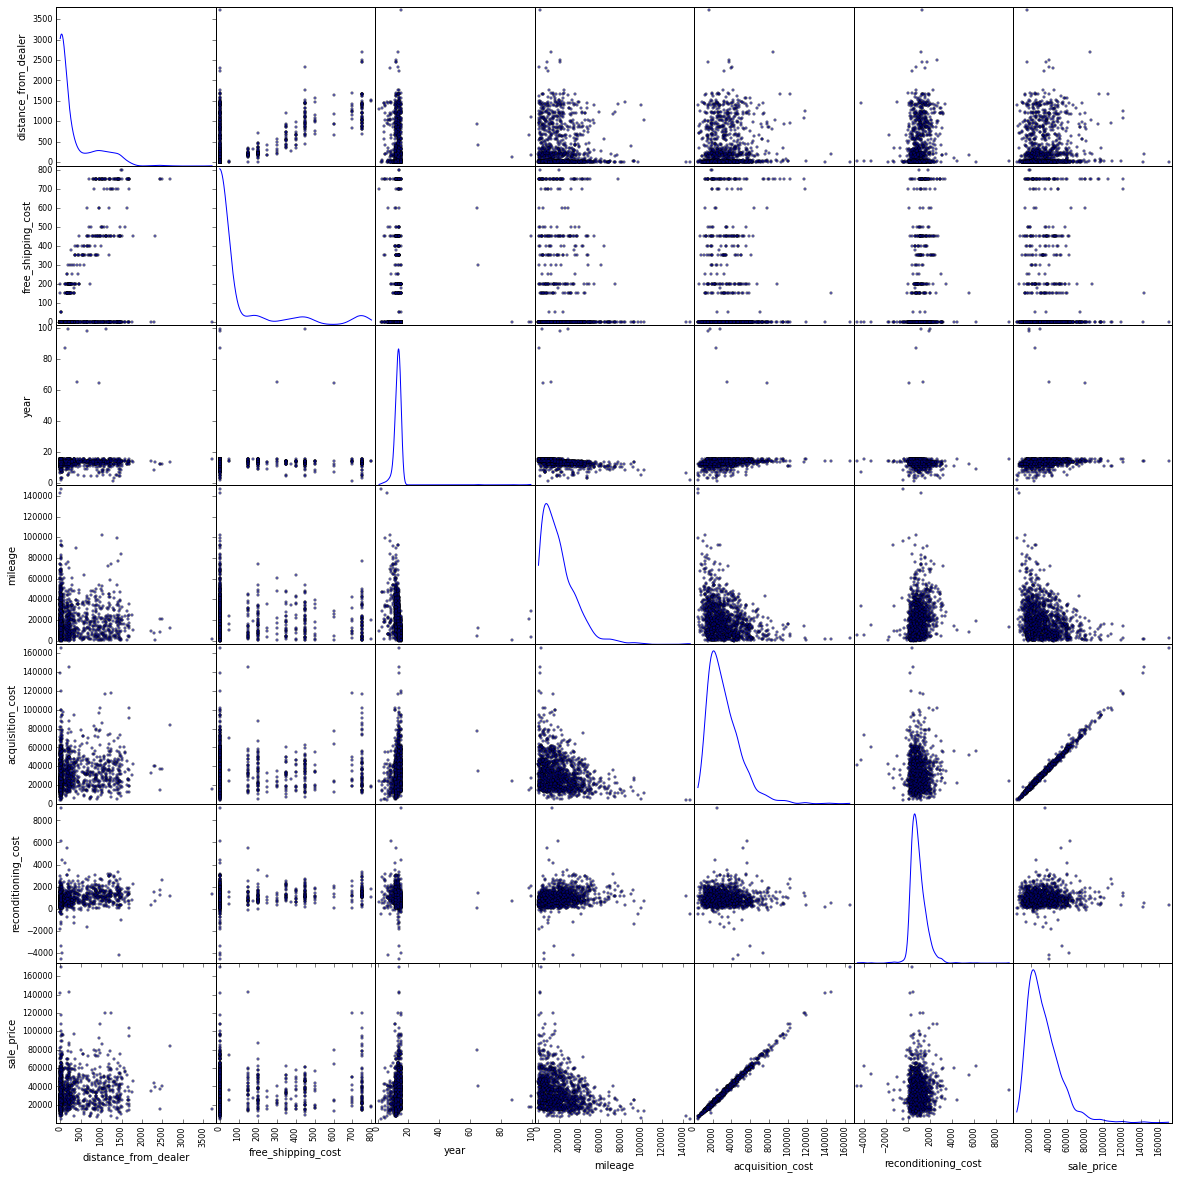

In [3272]:
num_data = data[num_features]
num_data.corr()
pd.tools.plotting.scatter_matrix(num_data, figsize=(20,20), diagonal='kde')

In [ ]:
# Use countvectorize instead of factorize
# # factorize our labels since knn can only deal with numerical data
# # sales_source_index = pd.factorize(data['sales_source'])[1]
# # knn_data['sales_source'] = pd.factorize(data['sales_source'])[0]
# # body_index = pd.factorize(data['body'])[1]
# # knn_data['body'] = pd.factorize(data['body'])[0]
# color_index = pd.factorize(data['color'])[1]
# knn_data['color'] = pd.factorize(data['color'])[0]
# make_index = pd.factorize(data['make'])[1]
# knn_data['make'] = pd.factorize(data['make'])[0]
# model_index = pd.factorize(data['model'])[1]
# knn_data['model'] = pd.factorize(data['model'])[0]
# # pclass_index = pd.factorize(data['primary_class'])[1]
# # knn_data['pclass'] = pd.factorize(data['primary_class'])[0]
# # sclass_index = pd.factorize(data['secondary_class'])[1]
# # knn_data['secondary_class'] = pd.factorize(data['secondary_class'])[0]
# acq_source_index = pd.factorize(data['acq_source'])[1]
# knn_data['acq_source'] = pd.factorize(data['acq_source'])[0]
# age_group_index = pd.factorize(data['age_group'])[1]
# knn_data['age_group'] = pd.factorize(data['age_group'])[0]

In [3230]:
# Use KNN to predict age group
knn_data = data[num_features]

In [3273]:
# Use KNN to predict age group
knn_num_features = ['age_group','distance_from_dealer',
 'free_shipping_cost',
 'year',
 'mileage',
 'acquisition_cost',
 'reconditioning_cost']

# 'sale_price' - directly correlated w acq cost
knn_num = ' + '.join(num_features)

In [3282]:
obj_features = ['body',
 'color',
 'make',
 'model',
 'acq_source']

#'sales_source' - remove bc not known until car is sold
# 'dealer_range' since it's a function of distance
knn_obj = ') + C('.join(obj_features)
knn_obj = "C("+ knn_obj + ")"

In [3283]:
knn_y, knn_X = dmatrices('age_group ~ 0 +' + knn_num + '+' + knn_obj , data, return_type = 'dataframe')

In [3284]:
knn_scaler = StandardScaler(copy=True)
knn_X_scaled = knn_scaler.fit(knn_X).transform(knn_X)

In [3285]:
cv = KFold(len(y), 10, shuffle = True)
parameters = {'n_neighbors': range(1, 40), 'weights': ['distance'],
             'p': range(1, 2), 'algorithm': ['kd_tree']}
knn = KNeighborsClassifier()
classify = GridSearchCV(knn, parameters, n_jobs=3)
classify.fit(knn_X_scaled, knn_y)
print classify.best_estimator_
print cross_val_score(classify, knn_X_scaled, knn_y, cv=cv, scoring='accuracy').mean()

KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='minkowski',
           metric_params=None, n_neighbors=1, p=1, weights='distance')
0.331343283582


In [3011]:
# doing gridsearch
# gridsearch does its own CV
# this allows us to find the best parameters
# instead of tediously doing it ourselves!
cv = KFold(len(y), 10, shuffle = True)
parameters = {'n_neighbors': range(1, 40), 'weights': ['distance'],
             'p': range(1, 2), 'algorithm': ['kd_tree']}
knn = KNeighborsClassifier()
classify = GridSearchCV(knn, parameters, n_jobs=3)
classify.fit(knn_X_scaled, knn_y)
print classify.best_estimator_
#print cross_val_score(classify, knn_X, knn_y, cv=cv, scoring='mean_absolute_error').mean()
#why is this score negative?
print cross_val_score(classify, knn_X_scaled, knn_y, cv=cv, scoring='accuracy').mean()
#print cross_val_score(classify, knn_X, knn_y, cv=cv, scoring='mean_absolute_error')

KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='minkowski',
           metric_params=None, n_neighbors=1, p=1, weights='distance')
0.314925373134


In [2809]:
# how can i improve this score?

In [2810]:
#try to predict the age group of a car
age_group_index[classify.predict([0, 0, 13, 10000,50000,800,40000,50000,0,1,1,1])][0]

'poor'

In [3053]:
#Kmeans

In [3254]:
kmeans_features = []
for x in data.columns:
    kmeans_features.append(x)

kmeans_features

['distance_from_dealer',
 'sales_source',
 'free_shipping_cost',
 'stock_number',
 'car_class',
 'body',
 'color',
 'year',
 'make',
 'model',
 'mileage',
 'age',
 'trade_acv',
 'acquisition_cost',
 'reconditioning_cost',
 'total_cost',
 'sale_price',
 'front_gross',
 'financing',
 'warranty',
 'insurance',
 'other_products',
 'back_gross',
 'total_gross',
 'primary_class',
 'secondary_class',
 'acq_source',
 'age_group',
 'dealer_range']

In [3255]:
kmeans = data[['distance_from_dealer',
 'sales_source',
 'free_shipping_cost',
 'body',
 'color',
 'year',
 'make',
 'model',
 'mileage',
 'age',
 'trade_acv',
 'acquisition_cost',
 'reconditioning_cost',
 'total_cost',
 'sale_price',
 'front_gross',
 'financing',
 'warranty',
 'insurance',
 'other_products',
 'back_gross',
 'total_gross',
 'primary_class',
 'secondary_class',
 'acq_source',
 'age_group']]

In [3256]:
formula = ' + '.join(kmeans.columns)

In [3257]:
kmeans_data = dmatrix(formula + ' + 0', kmeans, return_type='dataframe')

In [3258]:
scale = StandardScaler()
kmeans_scale = scale.fit(kmeans_data).transform(kmeans_data)

In [3259]:
km = KMeans(n_clusters=3)
km.fit(kmeans_scale)

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=3, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=None, tol=0.0001,
    verbose=0)

In [3260]:
print km.inertia_

649533.392683


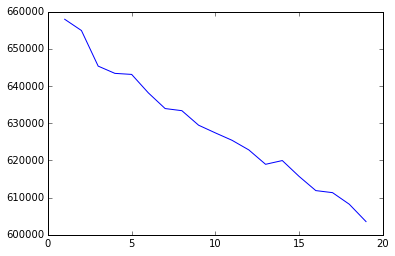

In [3122]:
x = []
y = []
np.random.seed(5)
for n in range(1,20):
    km2 = KMeans(n_clusters=n)
    km2.fit(kmeans_scale)
    x.append(n)
    y.append(km2.inertia_)
plt.plot(x, y)

In [3261]:
# rerun with 3 based on elbow around 3
km = KMeans(n_clusters=3)
km.fit(kmeans_scale)

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=3, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=None, tol=0.0001,
    verbose=0)

In [3262]:
km.predict(kmeans_scale)

array([0, 0, 2, ..., 0, 2, 2], dtype=int32)

In [3263]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
columns = {str(x): scale.inverse_transform(km.cluster_centers_[x]) for x in range(0,3)}
pd.DataFrame(columns, index=kmeans_data.columns)

,0,1,2
sales_source[autotrader],0.150,0.125,0.180
sales_source[cargurus],0.184,0.250,0.153
sales_source[cars.com],0.077,-0.000,0.083
sales_source[ebay],0.325,0.250,0.306
sales_source[google],0.064,0.125,0.043
sales_source[kbb],-0.000,-0.000,0.001
sales_source[known_other],0.137,0.188,0.194
sales_source[unknown],0.064,0.062,0.040
body[T.2D Convertible],-0.000,-0.000,0.050
body[T.2D Coupe],0.000,0.250,0.119


In [3265]:
kmeans_data['segments'] = km.labels_

In [3266]:
kmeans_data.segments.value_counts()

2    1090
0     234
1      16
dtype: int64

In [3268]:
kmeans_data[kmeans_data.segments==2]

,sales_source[autotrader],sales_source[cargurus],sales_source[cars.com],sales_source[ebay],sales_source[google],sales_source[kbb],sales_source[known_other],sales_source[unknown],body[T.2D Convertible],body[T.2D Coupe],...,total_cost,sale_price,front_gross,financing,warranty,insurance,other_products,back_gross,total_gross,segments
2,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,1.000,...,118644.660,119996.000,726.340,734.290,0.000,0.000,0.000,734.290,1460.630,2
3,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,1.000,0.000,...,18353.650,17796.000,-1182.650,0.000,0.000,0.000,0.000,0.000,-1182.650,2
4,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,15359.840,16998.000,1763.160,0.000,0.000,0.000,0.000,0.000,1763.160,2
5,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,12539.110,12996.000,581.890,424.680,1000.000,0.000,555.000,1979.680,2561.570,2
6,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,...,52026.750,53898.000,1996.250,229.120,0.000,0.000,356.000,585.120,2581.370,2
7,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,35666.750,35996.000,454.250,0.000,0.000,0.000,317.000,317.000,771.250,2
8,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,16995.870,15996.000,-874.870,0.000,0.000,0.000,0.000,0.000,-874.870,2
9,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,16668.520,16796.000,252.480,635.570,1000.000,392.000,555.000,2582.570,2835.050,2
13,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,...,24240.140,23996.000,-119.140,1352.490,1000.000,392.000,0.000,2744.490,2625.350,2
14,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,21933.980,21886.000,-72.980,334.320,0.000,0.000,356.000,690.320,617.340,2
